In [ ]:
import sys
sys.path.insert(0, '../code')
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mne.stats import permutation_cluster_1samp_test
from scipy.ndimage import gaussian_filter
import re
import matplotlib.pyplot as plt
import matplotlib
from temp_gen_group_functions import *


## Load data

In [8]:
data_dir = '../data/derivatives/temporal_generalisation/'
subs = [i for i in os.listdir(data_dir) if 'sub' in i]
subs = sorted(subs)
print('Number of subjects = {}'.format(len(subs)))

Number of subjects = 28


In [9]:
parameter_estimates = pd.read_csv('../data/derivatives/behavioural_modelling/parameter_estimates_renamed.csv')
parameter_estimates = parameter_estimates[parameter_estimates.Subject.isin(subs)]
parameter_estimates = parameter_estimates.sort_values('Subject')
parameter_estimates.head()

,Subject,generalisation,alpha_p,alpha_n,temperature
15,sub-001,0.739,0.597,0.656,0.324
24,sub-002,0.531,0.742,0.259,0.600
26,sub-003,0.335,0.689,0.678,0.604
21,sub-004,0.520,0.245,0.550,0.617
25,sub-005,0.621,0.595,0.674,0.570


In [16]:
temporal_generalisation_scores = dict()

temporal_generalisation_scores['outcome'] = dict(all_trials=dict(learning=[], generalisation=[], end=[]))
temporal_generalisation_scores['planning'] = dict(all_trials=dict(learning=[], generalisation=[], end=[]),
                                        learning_trials=dict(learning=[], generalisation=[], end=[]),
                                        generalisation_trials=dict(learning=[], generalisation=[], end=[]))

for sub in subs:
    
    for states in ['learning', 'generalisation', 'end']:
        if load_and_filter(os.path.join(data_dir, sub, 'temporal_generalisation', 'outcome', 'all_trials', '{0}_{1}_stimulus_outcome.npy'.format(sub, states))).shape[1] == 280:
            print(sub)
        temporal_generalisation_scores['planning']['all_trials'][states].append(load_and_filter(os.path.join(data_dir, sub, 'temporal_generalisation', 'planning', 'all_trials', '{0}_{1}_stimulus_planning.npy'.format(sub, states))))
        temporal_generalisation_scores['outcome']['all_trials'][states].append(load_and_filter(os.path.join(data_dir, sub, 'temporal_generalisation', 'outcome', 'all_trials', '{0}_{1}_stimulus_outcome.npy'.format(sub, states))))
        temporal_generalisation_scores['planning']['learning_trials'][states].append(load_and_filter(os.path.join(data_dir, sub, 'temporal_generalisation', 'planning', 'learning_trials', '{0}_{1}_stimulus_planning.npy'.format(sub, states))))
        temporal_generalisation_scores['planning']['generalisation_trials'][states].append(load_and_filter(os.path.join(data_dir, sub, 'temporal_generalisation', 'planning', 'generalisation_trials', '{0}_{1}_stimulus_planning.npy'.format(sub, states))))

for states in ['learning', 'generalisation', 'end']:

    temporal_generalisation_scores['planning']['all_trials'][states] = np.stack(temporal_generalisation_scores['planning']['all_trials'][states])

    temporal_generalisation_scores['outcome']['all_trials'][states] = np.stack([i for i in temporal_generalisation_scores['outcome']['all_trials'][states] if i.shape[1] == 400])
    temporal_generalisation_scores['planning']['learning_trials'][states] = np.stack(temporal_generalisation_scores['planning']['learning_trials'][states])
    temporal_generalisation_scores['planning']['generalisation_trials'][states] = np.stack(temporal_generalisation_scores['planning']['generalisation_trials'][states])



## Plots

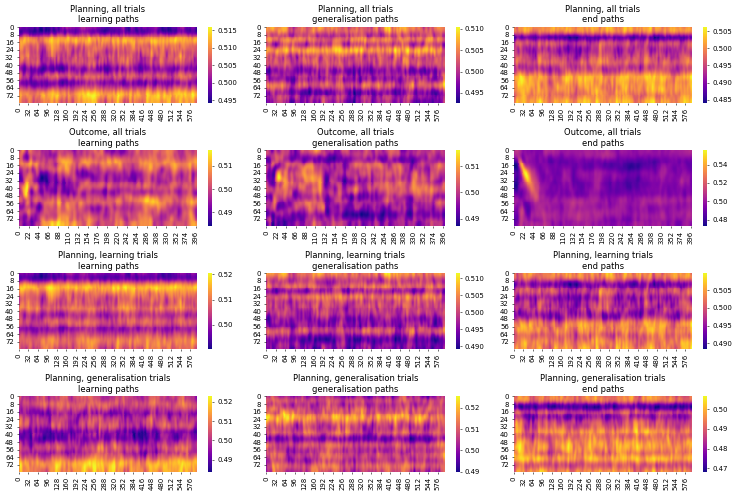

In [19]:
fig, ax = plt.subplots(4, 3, figsize=(15, 10), dpi=50)

for n, i in enumerate(['learning', 'generalisation', 'end']):
    sns.heatmap(temporal_generalisation_scores['planning']['all_trials'][i][:, :, :].mean(axis=0), cmap='plasma', ax=ax[0, n])
    ax[0, n].set_title('Planning, all trials\n{0} paths'.format(i))
    sns.heatmap(temporal_generalisation_scores['outcome']['all_trials'][i][:, :, :].mean(axis=0), cmap='plasma', ax=ax[1, n])
    ax[1, n].set_title('Outcome, all trials\n{0} paths'.format(i))
    sns.heatmap(temporal_generalisation_scores['planning']['learning_trials'][i][:, :, :].mean(axis=0), cmap='plasma', ax=ax[2, n])
    ax[2, n].set_title('Planning, learning trials\n{0} paths'.format(i))
    sns.heatmap(temporal_generalisation_scores['planning']['generalisation_trials'][i][:, :, :].mean(axis=0), cmap='plasma', ax=ax[3, n])
    ax[3, n].set_title('Planning, generalisation trials\n{0} paths'.format(i))

plt.tight_layout()

## Main analyses

### Reactivation of initial states from learning paths, learning trials

In [22]:
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(temporal_generalisation_scores['planning']['learning_trials']['learning'] - 0.5, n_permutations=1000, tail=0)
cluster_p_values[cluster_p_values < .05]

Using a threshold of 2.051831
stat_fun(H1): min=-2.258445 max=4.737508
Running initial clustering
Found 32 clusters
Permuting 999 times...


<ipython-input-22-c226fbe2563e>:1: DeprecationWarning: The default for "out_type" will change from "mask" to "indices" in version 0.22. To avoid this warning, explicitly set "out_type" to one of its string values.
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(temporal_generalisation_scores['planning']['learning_trials']['learning'] - 0.5, n_permutations=1000, tail=0)


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


array([0.026])

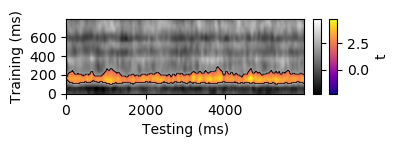

In [23]:
plot_clusters(T_obs, clusters, cluster_p_values, threshold=0.05, cmap='plasma')

### Reactivation of end states at outcome

In [24]:
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(temporal_generalisation_scores['outcome']['all_trials']['end'][:, :, 120:] - 0.5, n_permutations=1000, tail=0)
cluster_p_values[cluster_p_values < .05]

Using a threshold of 2.051831
stat_fun(H1): min=-5.263647 max=3.512785
Running initial clustering
Found 17 clusters
Permuting 999 times...


<ipython-input-24-d683a17e2f6c>:1: DeprecationWarning: The default for "out_type" will change from "mask" to "indices" in version 0.22. To avoid this warning, explicitly set "out_type" to one of its string values.
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(temporal_generalisation_scores['outcome']['all_trials']['end'][:, :, 120:] - 0.5, n_permutations=1000, tail=0)


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


array([0.005])

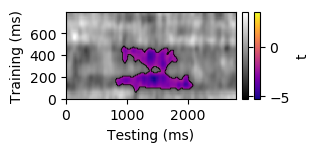

In [25]:
plot_clusters(T_obs, clusters, cluster_p_values, threshold=0.05, cmap='plasma', end=2800, figsize=(2.5, 1.5))
# plt.savefig('../figures/temp_gen_outcome_end.svg')

### Correlation between generalisation parameter and end state reactivation, generalisation trials

In [27]:
from scipy import stats
threshold = stats.distributions.t.ppf(1 - (0.05 / 2), len(subs))

x = parameter_estimates['generalisation'].values
x = np.vstack([np.ones_like(x), x]).T  # Add intercept
y = temporal_generalisation_scores['planning']['generalisation_trials']['end']

T_obs, clusters, cluster_p_values = permutation_lm_test(x, y, threshold=threshold, plot=False)

../code/temp_gen_group_functions.py:142: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, resid_sum_squares, _, _ = linalg.lstsq(a=design_matrix, b=y)
  0%|          | 2/1000 [00:00<01:16, 12.97it/s]

Found 29 clusters


100%|██████████| 1000/1000 [00:49<00:00, 20.08it/s]

[0.77822178 0.82817183 0.55144855 0.54345654 0.63736264 0.75924076
 0.77222777 0.72127872 0.62637363 0.81118881 0.04195804 0.03596404
 0.10889111 0.44455544 0.24575425 0.58941059 0.48351648 0.56243756
 0.73226773 0.48651349 0.38961039 0.64135864 0.72827173 0.50549451
 0.8011988  0.66033966 0.62037962 0.67932068 0.72427572]


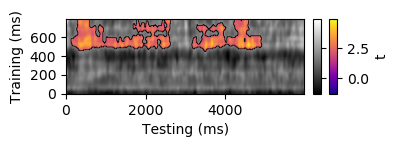

In [28]:
plot_clusters(T_obs, clusters, cluster_p_values, threshold=0.05, cmap='plasma')
# plt.axhline(np.argmax(T_obs.mean(axis=1)))
# plt.savefig('../figures/temp_gen_planning_end_generalisation_correlation.svg')